# Lab Deep Learning/ Recurrent Neural Networks/ in keras

## Training language model (Many-to-Many) and generating sequences (One-to-Many)

**Author: geoffroy.peeters@telecom-paris.fr**

**Version**: 2020/10/05 (changed to tensorfow.keras)

For any remark or suggestion, please feel free to contact me.


## Objective:

- We will train a network to learn a language model and then use it to generate new sequences.

- Instead of training the language model on text-documents (as it is the case in most examples) we will train it to learn the language of the music of [Johann_Sebastian_Bach](https://en.wikipedia.org/wiki/Johann_Sebastian_Bach).
For this, we will learn how J. S. Bach's "Cello suite" have been composed.
Here is an example of a "Cello suite" [Link](https://www.youtube.com/watch?v=mGQLXRTl3Z0).

- Rather than analyzing the audio signal, we use a symbolic representation of the "Cello suite" through their [MIDI files](https://en.wikipedia.org/wiki/MIDI#MIDI_files).
  - A MIDI file encodes in a file, the set of musical notes, their duration, and intensity which have to be played by each instrument to "render" a musical piece. The "rendering" is usually operated by a MIDI synthesizer (such as VLC, QuickTime).

- We will first train a language model on the whole set of MIDI files of the "Cello suites". 
- We will then sample this language model to create a new MIDI file which will be a brand new "Cello suite" composed by the computer.

### Questions:

In the bottom part of this lab, you will have to answer a set of questions. Answers to those only necessitates a couple of sentences.

## Import packages

In [ ]:
! pip install pretty_midi
import os
import pretty_midi
from scipy.io import wavfile 
import IPython

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Flatten, Dropout, Activation, SimpleRNN

import matplotlib.pyplot as plt
import numpy as np
import glob

student = True

# Get the data

In [ ]:
n_x = 79
max_T_x = 1000
sequence_length = 20
T_y_generated = 200

## Collect data to create the language model

We download the 36 MIDI files corresponding to the 36 "Cello suites" composed by J. S. Bach.

In [ ]:
DIR = './'
import urllib.request
midiFile_l = ['cs1-2all.mid', 'cs5-1pre.mid', 'cs4-1pre.mid', 'cs3-5bou.mid', 'cs1-4sar.mid', 'cs2-5men.mid', 'cs3-3cou.mid', 'cs2-3cou.mid', 'cs1-6gig.mid', 'cs6-4sar.mid', 'cs4-5bou.mid', 'cs4-3cou.mid', 'cs5-3cou.mid', 'cs6-5gav.mid', 'cs6-6gig.mid', 'cs6-2all.mid', 'cs2-1pre.mid', 'cs3-1pre.mid', 'cs3-6gig.mid', 'cs2-6gig.mid', 'cs2-4sar.mid', 'cs3-4sar.mid', 'cs1-5men.mid', 'cs1-3cou.mid', 'cs6-1pre.mid', 'cs2-2all.mid', 'cs3-2all.mid', 'cs1-1pre.mid', 'cs5-2all.mid', 'cs4-2all.mid', 'cs5-5gav.mid', 'cs4-6gig.mid', 'cs5-6gig.mid', 'cs5-4sar.mid', 'cs4-4sar.mid', 'cs6-3cou.mid']
for midiFile in midiFile_l:
  #if os.path.isfile(DIR + midiFile) is None:
  urllib.request.urlretrieve ("http://www.jsbach.net/midi/" + midiFile, DIR + midiFile)
nbExample = len(midiFile_l)

midiFile_l = glob.glob(DIR + 'cs*.mid')
print(midiFile_l)

['./cs3-3cou.mid', './cs1-3cou.mid', './cs6-4sar.mid', './cs2-5men.mid', './cs2-1pre.mid', './cs3-4sar.mid', './cs6-2all.mid', './cs3-1pre.mid', './cs5-1pre.mid', './cs5-4sar.mid', './cs1-1pre.mid', './cs4-4sar.mid', './cs3-5bou.mid', './cs5-5gav.mid', './cs6-1pre.mid', './cs4-6gig.mid', './cs4-1pre.mid', './cs4-3cou.mid', './cs2-4sar.mid', './cs5-2all.mid', './cs4-5bou.mid', './cs1-5men.mid', './cs2-6gig.mid', './cs5-6gig.mid', './cs3-6gig.mid', './cs6-6gig.mid', './cs1-2all.mid', './cs2-3cou.mid', './cs1-4sar.mid', './cs3-2all.mid', './cs6-3cou.mid', './cs1-6gig.mid', './cs4-2all.mid', './cs5-3cou.mid', './cs6-5gav.mid', './cs2-2all.mid']


## Read and convert all MIDI files

In [ ]:
# --- Read a single MIDI file
midi_data = pretty_midi.PrettyMIDI(midiFile_l[0])
# --- Display the note pitch, start, end and duration
for note in midi_data.instruments[0].notes:
    print('pitch: %d, start: %f, end: %f, duration: %f' % (note.pitch, note.start, note.end, note.end-note.start))

pitch: 60, start: 0.600000, end: 0.793548, duration: 0.193549
pitch: 60, start: 0.793548, end: 0.987097, duration: 0.193548
pitch: 55, start: 0.987097, end: 1.180645, duration: 0.193548
pitch: 52, start: 1.180645, end: 1.374194, duration: 0.193549
pitch: 48, start: 1.374194, end: 1.567742, duration: 0.193548
pitch: 43, start: 1.567742, end: 1.761291, duration: 0.193549
pitch: 40, start: 1.761291, end: 1.954839, duration: 0.193548
pitch: 36, start: 1.954839, end: 2.148388, duration: 0.193548
pitch: 60, start: 2.148388, end: 2.341936, duration: 0.193548
pitch: 62, start: 2.341936, end: 2.535485, duration: 0.193548
pitch: 60, start: 2.535485, end: 2.729033, duration: 0.193549
pitch: 59, start: 2.729033, end: 2.922582, duration: 0.193548
pitch: 60, start: 2.922582, end: 3.116130, duration: 0.193548
pitch: 62, start: 3.116130, end: 3.309679, duration: 0.193548
pitch: 59, start: 3.309679, end: 3.503227, duration: 0.193548
pitch: 55, start: 3.503227, end: 3.696776, duration: 0.193549
pitch: 5

We read all MIDI files and convert their content to one-hot-encoding matrix X_ohe of dimensions (T_x, n_x) where n_x is the number of possible musical notes.
The duration of the sequences T_x can vary from one sequence to the other.
 


In [ ]:
# --- We truncate the duration of each example to the first T_x data

X_list = []

for midiFile in midiFile_l:
    # read the MIDI file
    midi_data = pretty_midi.PrettyMIDI(midiFile)
    note_l = [note.pitch for note in midi_data.instruments[0].notes]
    # convert to one-hot-encoding
    T_x = len(note_l)
    if T_x > max_T_x:
      T_x = max_T_x
    X_ohe = np.zeros((T_x, n_x))
    for t in range(T_x): 
      X_ohe[t, note_l[t]-1] = 1
    # add to the list  
    X_list.append(X_ohe)
    
print(len(X_list))
print(X_list[0].shape)
print(X_list[1].shape)
print(X_list[2].shape)

36
(984, 79)
(812, 79)
(162, 79)


## Display the set of notes over time for a specific track 

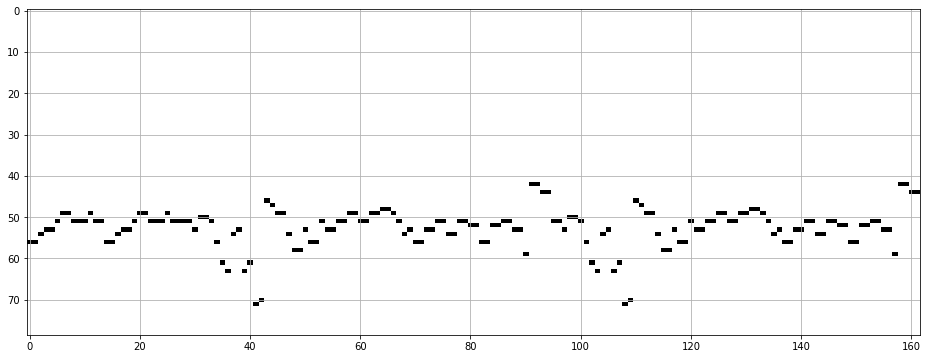

In [ ]:
plt.figure(figsize=(16, 6))
plt.imshow(X_list[2].T, aspect='auto')
plt.set_cmap('gray_r')
plt.grid(True)

## Data conversion for the training of language model

For each example/sequence and each possible starting note in this example/sequence, we create two sequences
- an input sequence: 
  - which contains a sub-sequence of length ```sequence_length```;  this sub-sequence range from the note $t$ to the note $t+sequence\_length-1$
- an output sequence:
  - which contains the following note to be predicted, the one at position $t+sequence\_length$

The training is therefore performed by giving to the model a set of sequences as input and asking the network to predict each time the note that should come right after this sequence.

<img src="https://perso.telecom-paristech.fr/gpeeters/doc/Lab_DL_RNN_02.png">


In [ ]:
X_train_list = []
y_train_list = []

if student:
    # --- START CODE HERE (01)
     for i in range(len(X_list)):
      t=0
      while(t+sequence_length-1 < X_list[i].shape[0]-1):
        X_train_list.append(X_list[i][t:t+sequence_length,])
        y_train_list.append(X_list[i][t+sequence_length,])
        t+=1
    # --- END CODE HERE
    
X_train = np.asarray(X_train_list)
y_train = np.asarray(y_train_list)

print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)

X_train.shape: (24141, 10, 79)
y_train.shape: (24141, 79)


# Training the language model

The language model will be learned by training an RNN with input `X_train` and output `Y_train`:  for each of the examples of sequences, we give to the network a sequence of notes of `sequence_length` duration, and ask the network to predict the following note of each sequence.

The network will have the following structure
- (1a) a layer of `LSTM` with $n_a$=256
- (1b) a layer of DropOut with rate 0.3 (the probability to "drop-out" one neuron is 0.3)
- (2a) a layer of `LSTM` with $n_a$=256
- (2b) a layer of DropOut with rate 0.3 (the probability to "drop-out" one neuron is 0.3)
- (3) a layer of `LSTM` with $n_a$=256
- (4a) a layer of `Dense` with 256 units
- (4b) a layer of DropOut with rate 0.3 (the probability to "drop-out" one neuron is 0.3)
- (5) a layer of `Dense` with a `softmax` activation which predict the probability of each of the $n_x$ notes as output

## Returning the hidden states at each time of an LSTM cell

Note that when we stack one LSTM layer on top of another LSTM layer, we need to tell the bottom LSTM to output its hidden states at each time $t$. This is done by the option `return_sequences=True` that has to be given as parameter to the LSTM on top of the other one.
This is the case for (1a) which is used by (2a) and for (2a) with is used by (3).

However, since we are only interrested in the last hidden state of the third LSTM (since we are only interrest in its prediction at time $T_x$), we give the option `return_sequences=False` (which is the default behaviour) for the third LSTM.
This is the case for (3).

In [ ]:
# --- Create the model
K.clear_session()

if student:
    # --- START CODE HERE (02)
    model = Sequential()
    model.add(LSTM(256, return_sequences= True))
    model.add(Dropout(0.3))
    model.add(LSTM(256, return_sequences= True))
    model.add(Dropout(0.3))
    model.add(LSTM(256, return_sequences= False))
    model.add(Dense(256))
    model.add(Dropout(0.3))
    model.add(Dense(n_x, activation= "softmax"))
    model.build(X_train.shape)
    # --- END CODE HERE

    print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (24141, 10, 256)          344064    
_________________________________________________________________
dropout (Dropout)            (24141, 10, 256)          0         
_________________________________________________________________
lstm_1 (LSTM)                (24141, 10, 256)          525312    
_________________________________________________________________
dropout_1 (Dropout)          (24141, 10, 256)          0         
_________________________________________________________________
lstm_2 (LSTM)                (24141, 256)              525312    
_________________________________________________________________
dense (Dense)                (24141, 256)              65792     
_________________________________________________________________
dropout_2 (Dropout)          (24141, 256)              0

In [ ]:
# --- Compile and fit the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
378/378 [==============================] - 3s 8ms/step - loss: 2.9230 - accuracy: 0.1195
Epoch 2/10
378/378 [==============================] - 3s 8ms/step - loss: 2.6184 - accuracy: 0.1611
Epoch 3/10
378/378 [==============================] - 3s 8ms/step - loss: 2.5460 - accuracy: 0.1823
Epoch 4/10
378/378 [==============================] - 3s 8ms/step - loss: 2.4913 - accuracy: 0.2067
Epoch 5/10
378/378 [==============================] - 3s 8ms/step - loss: 2.4236 - accuracy: 0.2414
Epoch 6/10
378/378 [==============================] - 3s 8ms/step - loss: 2.3301 - accuracy: 0.2862
Epoch 7/10
378/378 [==============================] - 3s 8ms/step - loss: 2.2102 - accuracy: 0.3257
Epoch 8/10
378/378 [==============================] - 3s 8ms/step - loss: 2.0862 - accuracy: 0.3663
Epoch 9/10
378/378 [==============================] - 3s 8ms/step - loss: 1.9297 - accuracy: 0.4124
Epoch 10/10
378/378 [==============================] - 3s 8ms/step - loss: 1.7699 - accuracy: 0.4574

# Generating a new sequence from sampling the language model

To generate a new sequence from the language model, we simply give it as input a random sequence of duration ```sequence_length```and ask the trained network to predict the output (using ```model.predict```). 

The output of the network is a vector of probability of dimension $n_x$ which represents the probability of each note to be the next note of the melody given as input.

From this vector, we select the note which has the maximum probability.

We then concatenate this new note (its one-hot-encoding representation) at the end of the input sequence.
We finally remove the first element of the input sequence to keep its duration constant (```sequence_length```).

Instead of providing a random sequence as input, we rather randomly select one sequence out of the 23.781 sequences used for training.

- The ```pattern``` variable is the ```list``` of init notes to which we progressively append the new generated notes by the model.
- The ```prediction``` variable is a ```list``` which stores the softmax probability vector (a numpy array) corresponding to each generation time.


In [ ]:
# --- Select a random starting pattern
start = np.random.randint(0, len(X_train_list)-1)
pattern = X_train_list[start]
print(start)
print(pattern.shape)
print(np.expand_dims(pattern, 0).shape)

4621
(10, 79)
(1, 10, 79)


In [ ]:
# --- note_l: is the list of notes (integer number) over time
note_l = []
# --- prediction_l: is the list of output-vectors (float numbers \in [0,1]) of the network over time
prediction_l = []
# --- Generate T_y_generated notes

note_l = [ j for i in range(sequence_length) for j in range(n_x) if(pattern[i][j]==1)]

for note_index in range(T_y_generated):
  
    if student:
        # --- START CODE HERE (03)
        prediction = model.predict(np.expand_dims(pattern, 0))
        prediction_l.append(prediction)
        new= np.zeros((1,n_x))
        p= np.argmax(prediction)
        new[0,p] = 1
        pattern=np.append(pattern,new, axis= 0)
        pattern=np.delete(pattern,0, axis = 0)
        note_l.append(p)
        note_index+=1
        # --- END CODE HERE    

### Display the generated sequence

[46, 54, 46, 39, 46, 54, 52, 51, 49, 47, 46, 47, 51, 47, 42, 49, 47, 46, 42, 42, 39, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42]


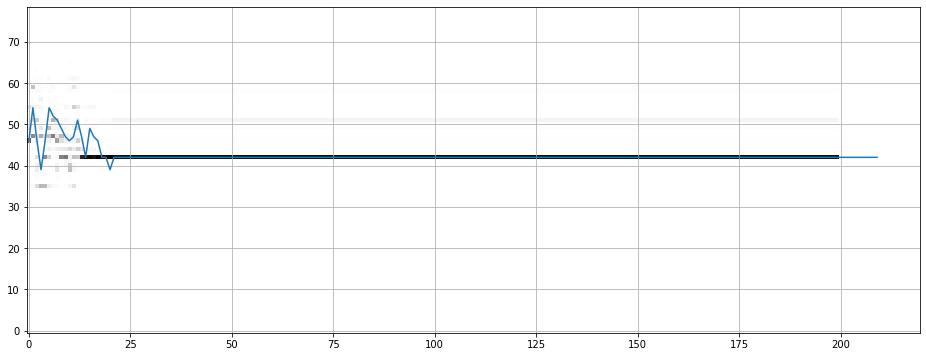

In [ ]:
print(note_l)

plt.figure(figsize=(16, 6))
plt.imshow(np.asarray(prediction_l)[:,0,:].T, aspect='auto', origin='lower')
plt.plot(note_l)
plt.set_cmap('gray_r')
plt.grid(True)


### Create a MIDI file and an audio file which correspond to the generated sequence

Once the new sequence has been generated (```note_l```) we transform it to a new MIDI file and perform (a very cheap) rendering of it in an audio file.

In [ ]:
new_midi_data = pretty_midi.PrettyMIDI()
cello_program = pretty_midi.instrument_name_to_program('Cello')
cello = pretty_midi.Instrument(program=cello_program)
time = 0
step = 0.3
for note_number in note_l:
    myNote = pretty_midi.Note(velocity=100, pitch=note_number, start=time, end=time+step)
    cello.notes.append(myNote)
    time += step
new_midi_data.instruments.append(cello)
new_midi_data.write('output.mid')

In [ ]:
%matplotlib inline

audio_data = new_midi_data.synthesize()
IPython.display.Audio(audio_data, rate=44100)